# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

## Inspecting the data

Let's start by inspecting what kind of data we have.

In [2]:
df = pd.read_csv("fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv")

In [3]:
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [4]:
print("Unique days in the dataset: {}".format(len(df["Date"].unique())))

Unique days in the dataset: 4017


In [5]:
print("Observations in the dataset: {}".format(df.shape[0]))

Observations in the dataset: 165085


It seems that our data contains 165085 observations for 4017 days. So there are several observations per day. Let's see how the date looks if we sort it by the date. 

In [6]:
df.sort_values("Date").head()

,ID,Date,Element,Data_Value
60995,USW00004848,2005-01-01,TMIN,0
17153,USC00207320,2005-01-01,TMAX,150
17155,USC00207320,2005-01-01,TMIN,-11
10079,USW00014833,2005-01-01,TMIN,-44
10073,USW00014833,2005-01-01,TMAX,33


## Preprocessing for the plot

We will be working on month and day basis so let's extract this information to own column.

In [7]:
# Add month-day column so we can find record breaking days from 2015
df["Month-Day"] = df.apply(lambda row: "-".join(row["Date"].split("-")[1:]), axis=1)

In [8]:
df[ df["Month-Day"] == "01-01" ].min()

ID            USC00200032
Date           2005-01-01
Element              TMAX
Data_Value           -160
Month-Day           01-01
dtype: object

Before going further drop leap day from the date set like instructed.

In [9]:
df = df[ df.Date.str.contains("-02-29") == False ]

Let's now convert dates from string to date object.

In [10]:
df.dtypes

ID            object
Date          object
Element       object
Data_Value     int64
Month-Day     object
dtype: object

In [11]:
df["Date"] = pd.to_datetime(df["Date"])

In [12]:
df.dtypes

ID                    object
Date          datetime64[ns]
Element               object
Data_Value             int64
Month-Day             object
dtype: object

Let's now separate min and max for easier handling.

In [13]:
tmax = df[ df["Element"] == "TMAX" ]
tmin = df[ df["Element"] == "TMIN" ]

In [14]:
tmin.sort_values("Date").head()

,ID,Date,Element,Data_Value,Month-Day
18232,USC00205050,2005-01-01,TMIN,-17,01-01
24805,USW00094889,2005-01-01,TMIN,-56,01-01
17155,USC00207320,2005-01-01,TMIN,-11,01-01
35479,USC00201502,2005-01-01,TMIN,-39,01-01
49827,USC00200228,2005-01-01,TMIN,-39,01-01


In [15]:
tmax.sort_values("Date").head()

,ID,Date,Element,Data_Value,Month-Day
3058,USC00205822,2005-01-01,TMAX,128,01-01
55102,USC00200032,2005-01-01,TMAX,67,01-01
41334,USC00208080,2005-01-01,TMAX,33,01-01
17153,USC00207320,2005-01-01,TMAX,150,01-01
39569,USC00200842,2005-01-01,TMAX,144,01-01


Group to 2005-2014 and 2015 to own datasets.

We also need to find dates when record low and high were broken in 2015. Strategy here is to merge min/max and 2015 data frames on 'month-day', keep only high/low for each day and keep 2015 values only if they are lower or higher than day observation for period 2005-2014.

In [16]:
# Take year earlier than 2015
df_period_min = tmin[ tmin["Date"] < "2015-01-01" ]
df_period_max = tmax[ tmax["Date"] < "2015-01-01" ]

# Separate 2015
df_2015_min = tmin[ tmin["Date"] >= "2015-01-01" ]
df_2015_max = tmax[ tmax["Date"] >= "2015-01-01" ]

In [17]:
tmax_grouped = df_period_max.groupby("Month-Day").max()
tmin_grouped = df_period_min.groupby("Month-Day").min()

tmax_15_grouped = df_2015_max.groupby("Month-Day").max()
tmin_15_grouped = df_2015_min.groupby("Month-Day").min()

In [18]:
tmin_15_grouped = tmin_15_grouped.reset_index()
df_min= tmin_grouped.reset_index().merge(tmin_15_grouped, on="Month-Day").set_index("Month-Day")

tmax_15_grouped = tmax_15_grouped.reset_index()
df_max= tmax_grouped.reset_index().merge(tmax_15_grouped, on="Month-Day").set_index("Month-Day")

df_max.rename(columns={"Data_Value_y":"Data_Max_2015", "Data_Value_x" : "Data_Value"}, inplace=True)
df_min.rename(columns={"Data_Value_y":"Data_Min_2015", "Data_Value_x" : "Data_Value"}, inplace=True)

In [19]:
df_max.head()

,ID_x,Date_x,Element_x,Data_Value,ID_y,Date_y,Element_y,Data_Max_2015
Month-Day,,,,,,,,
01-01,USW00094889,2014-01-01,TMAX,156,USW00094889,2015-01-01,TMAX,11
01-02,USW00094889,2014-01-02,TMAX,139,USW00094889,2015-01-02,TMAX,39
01-03,USW00094889,2014-01-03,TMAX,133,USW00014853,2015-01-03,TMAX,39
01-04,USW00094889,2014-01-04,TMAX,106,USW00094889,2015-01-04,TMAX,44
01-05,USW00094889,2014-01-05,TMAX,128,USW00094889,2015-01-05,TMAX,28


In [20]:
df_min.head()

,ID_x,Date_x,Element_x,Data_Value,ID_y,Date_y,Element_y,Data_Min_2015
Month-Day,,,,,,,,
01-01,USC00200032,2005-01-01,TMIN,-160,USC00200032,2015-01-01,TMIN,-133
01-02,USC00200032,2005-01-02,TMIN,-267,USC00200032,2015-01-02,TMIN,-122
01-03,USC00200032,2005-01-03,TMIN,-267,USC00200032,2015-01-03,TMIN,-67
01-04,USC00200032,2005-01-04,TMIN,-261,USC00200032,2015-01-04,TMIN,-88
01-05,USC00200032,2005-01-05,TMIN,-150,USC00200032,2015-01-05,TMIN,-155


For 2015 columns keep values only if value is higher or lower than for 2005-2014 months. Setting values to ```np.NaN``` is a good way of setting value to none since ```NaN``` values are not included in plot or in possible calculations.

In [21]:
df_min["Data_Min_2015"] = df_min.apply(lambda row: row["Data_Min_2015"] if (row["Data_Min_2015"] < row["Data_Value"]) else np.NaN , axis=1)
df_max["Data_Max_2015"] = df_max.apply(lambda row: row["Data_Max_2015"] if (row["Data_Max_2015"] > row["Data_Value"]) else np.NaN , axis=1)

In [22]:
df_min = df_min.sort_index()
df_max = df_max.sort_index()

## Plotting the data

In [23]:
%matplotlib notebook

In [24]:
# Reset indexes so plots can be drawn
df_min = df_min.reset_index()
df_max = df_max.reset_index()

<IPython.core.display.Javascript object>


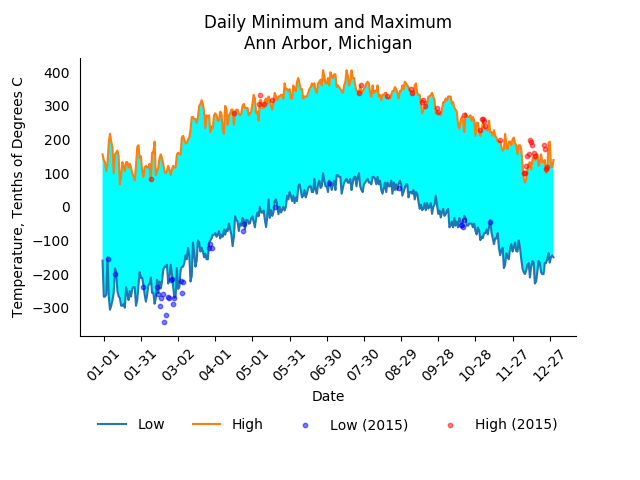

In [25]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

days = mdates.DayLocator()   # every day
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%m-%d')

fig, ax = plt.subplots()
ax.plot(df_min.index, df_min["Data_Value"], label="Low")
ax.plot(df_max.index, df_max["Data_Value"], label="High")


# format the ticks
#ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(fmt)
#ax.xaxis.set_minor_locator(months)

ax.scatter(df_min.index, df_min["Data_Min_2015"], s=10, c="blue", alpha=0.5, label="Low (2015)", zorder=10)
ax.scatter(df_max.index, df_max["Data_Max_2015"], s=10, c="red", alpha=0.5, label="High (2015)", zorder=10)

ax.fill_between(df_min.index, df_min["Data_Value"], df_max["Data_Value"], facecolor='cyan')

# Simplify graph
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.25), ncol=4, frameon = False)
ax.tick_params(top='off', bottom='on', left='off', right='off', labelleft='on', labelbottom='on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# set labels and title
plt.xlabel("Date")
plt.ylabel("Temperature, Tenths of Degrees C")
plt.title("Daily Minimum and Maximum\nAnn Arbor, Michigan")

ax.grid(False)
plt.xticks(np.arange(1, 365, 30), rotation=45)

# make some room for the legend
fig.subplots_adjust(bottom=0.3)

plt.show()